<a href="https://colab.research.google.com/github/abdipourasl/Deep-Learning-1402/blob/main/DL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-success">
<h1>Deep Learning Project #2<h1>
Amin Abdipour</h1>
</div>

#  ***Question 1***

### Importing Libraries

In [173]:
import numpy as np
import torch
import pandas as pd
import os
import os.path as op
import sklearn
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
drive.mount('/content/drive')
from google.colab.patches import cv2_imshow
from PIL import Image
from torch.utils.data import random_split, DataLoader
import torch.nn as nn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Import  Data

data type:  <class 'PIL.JpegImagePlugin.JpegImageFile'>


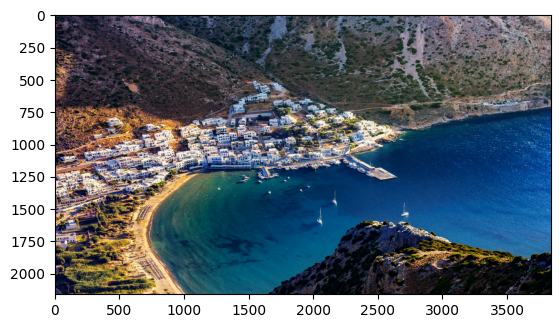

In [174]:
dir = op.join('/content/drive/My Drive/','DL','sifnos-greece-3840x2160-12799.jpg')  # Path to the Data folder
img = Image.open(dir)
print('data type: ', type(img))
plt.imshow(img)
plt.show()

### 2. Resize Data

data type:  <class 'PIL.Image.Image'>


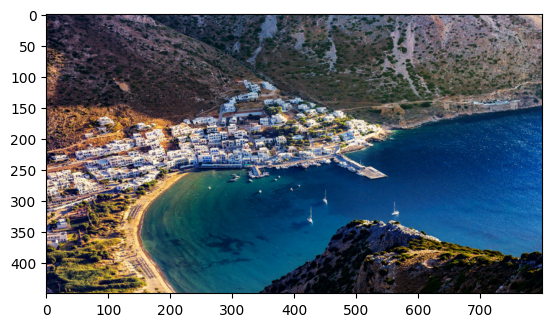

In [175]:
new_image = img.resize((800, 450))
print('data type: ', type(new_image))
plt.imshow(new_image)
plt.show()

PIL --->np.array

In [176]:
image = np.array(new_image)

### 3. Normalize Data

In [177]:
height, width, _ = image.shape
print(image.shape)

# Define functions for data preparation
def normalize_coordinates(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y, x

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, image, height, width):
    y = idx // width
    x = idx % width
    color = image[y, x]

    # Normalizing
    y, x = normalize_coordinates(y, x, height, width)
    color = normalize_color(color)

    return torch.tensor([y, x], dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

def get_full_image(image, height, width):
    # Return entire image with normalized coordinates for test stage
    coords = np.indices((height, width)).astype(np.float32)
    coords[0], coords[1] = normalize_coordinates(coords[0], coords[1], height, width)
    coords = torch.tensor(coords.reshape(2, -1).T, dtype=torch.float32)
    return coords, torch.tensor(image.reshape(-1, 3), dtype=torch.float32)

# Load dataset
dataset = [(get_item(idx, image, height, width)) for idx in range(height * width)]
dataset

(450, 800, 3)


[(tensor([0., 0.]), tensor([0.0000, 0.0157, 0.1294])),
 (tensor([0.0000, 0.0013]), tensor([0.0000, 0.0314, 0.1412])),
 (tensor([0.0000, 0.0025]), tensor([0.0039, 0.0510, 0.1412])),
 (tensor([0.0000, 0.0038]), tensor([0.0078, 0.0863, 0.1569])),
 (tensor([0.0000, 0.0050]), tensor([0.0196, 0.0980, 0.1725])),
 (tensor([0.0000, 0.0063]), tensor([0.0392, 0.1294, 0.1882])),
 (tensor([0.0000, 0.0075]), tensor([0.0392, 0.1176, 0.1647])),
 (tensor([0.0000, 0.0088]), tensor([0.0588, 0.0980, 0.1725])),
 (tensor([0.0000, 0.0100]), tensor([0.0235, 0.0706, 0.1569])),
 (tensor([0.0000, 0.0113]), tensor([0.0000, 0.0353, 0.1294])),
 (tensor([0.0000, 0.0125]), tensor([0.0039, 0.0392, 0.1373])),
 (tensor([0.0000, 0.0138]), tensor([0.0039, 0.0471, 0.1451])),
 (tensor([0.0000, 0.0150]), tensor([0.0392, 0.0863, 0.1725])),
 (tensor([0.0000, 0.0163]), tensor([0.0784, 0.1098, 0.2039])),
 (tensor([0.0000, 0.0175]), tensor([0.0549, 0.1059, 0.1882])),
 (tensor([0.0000, 0.0188]), tensor([0.0353, 0.0706, 0.1608])),


### 4. Split Data

In [178]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

### 6. Define Network Model

In [179]:
model = nn.Sequential(
    nn.Linear(2, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

### 5. Define Optimizer & Loss function

In [180]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


### 6. Train Model

In [181]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [182]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.026723
Epoch: 2 	Training Loss: 0.022907
Epoch: 3 	Training Loss: 0.022202
Epoch: 4 	Training Loss: 0.021751
Epoch: 5 	Training Loss: 0.021140
Epoch: 6 	Training Loss: 0.020878
Epoch: 7 	Training Loss: 0.020708
Epoch: 8 	Training Loss: 0.020189
Epoch: 9 	Training Loss: 0.020057
Epoch: 10 	Training Loss: 0.019952
Epoch: 11 	Training Loss: 0.019584
Epoch: 12 	Training Loss: 0.019478
Epoch: 13 	Training Loss: 0.019362
Epoch: 14 	Training Loss: 0.019045
Epoch: 15 	Training Loss: 0.018960
Epoch: 16 	Training Loss: 0.018950
Epoch: 17 	Training Loss: 0.018614
Epoch: 18 	Training Loss: 0.018566
Epoch: 19 	Training Loss: 0.018516
Epoch: 20 	Training Loss: 0.018270
Epoch: 21 	Training Loss: 0.018212
Epoch: 22 	Training Loss: 0.018194
Epoch: 23 	Training Loss: 0.017958
Epoch: 24 	Training Loss: 0.017948
Epoch: 25 	Training Loss: 0.017904
Epoch: 26 	Training Loss: 0.017697
Epoch: 27 	Training Loss: 0.017642
Epoch: 28 	Training Loss: 0.017632
Epoch: 29 	Training Loss: 0.0

In [183]:

model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

Epoch: 100 	Validation Loss: 0.014934


In [184]:

epochs = 15
e = np.zeros(1000)
error = np.zeros(epochs)
W = np.random.rand(3)
W


array([0.91527407, 0.8005366 , 0.82293023])

With w = cte, we test the effect of alpha

In [185]:
alpha = 1   # you can change it
w= W



### 3. Run Perceptron Algorithm

For every sample pair (S, t), do steps:
1. Set activations for i/p and o/p units , x=s for i=1:n
2. Adjust the weights: W(new) = W(old) + alpha.X.(t-y)
5. end


In [186]:
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error

NameError: ignored



### 4. Plot

Plot Error

In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'green')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


Plot Input Samples

In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(4, 12, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')




### 5. Change Alpha

**Alpha** = 0.01

In [ ]:
alpha = 0.01
w= W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'green')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(4, 12, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')
error

Alpha = 0.001

In [ ]:
alpha = 0.001
w= W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'green')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(4, 12, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')
error

Alpha = 0.00001

In [ ]:
alpha = 0.00001
w= W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'green')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(4, 12, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')
error

#  ***Question 3***

### 1. Import  Data

In [ ]:
from sklearn.datasets import make_moons
S, t = sklearn.datasets.make_moons(1000)
S0 = S[:,0]
S1 = S[:,1]

### 2. Initialize Parameters

In [ ]:
epochs = 100
e = np.zeros(1000)
error = np.zeros(epochs)
W = np.random.rand(5)
W


In [ ]:
alpha = 0.01   # you can change it
w= W



### 3. Run Perceptron Algorithm

For every sample pair (S, t), do steps:
1. Set activations for i/p and o/p units , x=s for i=1:n
2. Adjust the weights: W(new) = W(old) + alpha.X.(t-y)
3. end <h1>
  We can't seperate this data linearly, so we put S0^2 & S1^2 in inputs.


In [ ]:
for n in range(epochs):
  for i in range(100):
    X = [1,S0[i],S1[i],S0[i]**2,S1[i]**2]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error

**We Need Power 3 of Input, This data is not seperatable with dimention 2, So we add S0^3**

In [ ]:
alpha = 0.01   # you can change it
w= W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i],S0[i]**2,S0[i]**3]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error



### 4. Plot

Plot Error

In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'green')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


Plot Input Samples

In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-1, 1.5, 50)
y1 = (-1/w[2])*(w[1]*x1 + w[3]*(x1**2) + w[4]*(x1**3) + w[0])

pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('S0')
pyplot.ylabel('S1')


#  ***Question 4***

### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as plt
from matplotlib import pyplot
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

### Section 1: Linear Separable data

#### 1.1. Import  Data

In [ ]:
S, t = make_blobs(1200, centers=2)
S0 = S[:,0]
S1 = S[:,1]
t1 = t.copy()
for j in range(1200):
  if t[j]==0:
    t1[j] = -1

#### 1.2. Initialize Parameters

In [ ]:
epochs = 100
e = np.zeros(1000)
error = np.zeros(epochs)
W = np.random.rand(3)
alpha = 0.01   # you can change it
W


#### 1.3. Perceptron Algorithm

For every sample pair (S, t), do steps:
1. Set activations for i/p and o/p units , x=s for i=1:n
2. Adjust the weights: W(new) = W(old) + alpha.X.(t-y)
5. end


In [ ]:
w = W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error



#### 1.4. Plot

Plot Error

In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


Plot Input Samples

In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-6, 4, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')




#### 1.5. Test Perceptron Model

In [ ]:
y1 = np.zeros(200)
for i in range(200):
  X = [1,S0[i+1000],S1[i+1000]]
  y1[i] = np.heaviside(np.dot(X,w.T),1)
y1

In [ ]:
t[1000:]

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-6, 4, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')

#### 1.6. Run Adaline Algorithm

In [ ]:
w = W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.dot(X,w.T)
    y_sign = np.sign(np.dot(X,w.T))

    e[i] = t1[i]-y_sign
    w = w + alpha*np.array(X)*(t1[i]-y)

  error[n] = np.sum(np.abs(e))
error

In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-6, 4, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')


#### 1.6. Test Adaline Model

In [ ]:
y1 = np.zeros(200)
for i in range(200):
  X = [1,S0[i+1000],S1[i+1000]]
  y1[i] = np.sign(np.dot(X,w.T))
y1

In [ ]:
t1[1000:]

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-12.5, 0, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')

#### 1.7. Adaline + Perceptron

In [ ]:
e_adaline = np.zeros(1000)
w_adaline = np.random.rand(3)
w = np.random.rand(3)
for n in range(epochs):
  for i in range(1000):
    X_adaline = [0,S0[i],S1[i]]
    y_adaline = np.dot(X_adaline,w_adaline.T)
    y_sign_adaline = np.sign(np.dot(X_adaline,w_adaline.T))

    e_adaline[i] = t1[i]-y_sign_adaline
    w_adaline = w_adaline + alpha*np.array(X_adaline)*(t1[i]-y_adaline)

    w[0] = y_sign_adaline
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),0)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error


In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-12.5, 2.5, 10)
y1 = (-1/w_adaline[2])*(w_adaline[1]*x1)
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')


#### 1.8. Test Adaline + Perceptron Model

In [ ]:
y = y1 = np.zeros(200)
for i in range(200):
  X = [0,S0[i+1000],S1[i+1000]]
  y1[i] = np.sign(np.dot(X,w_adaline.T))
  w[0] = y1[i]
  X = [1,S0[i],S1[i]]
  y[i] = np.heaviside(np.dot(X,w.T),0)
y

In [ ]:
t[1000:]

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-5.5, 4, 10)
y1 = (-1/w_adaline[2])*(w_adaline[1]*x1)
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')

### Section 2: Quasi-linear Separable data

#### 2.1. Import  Data

In [ ]:
S, t = make_blobs(1200, centers=[[-1.2, 1.2], [1.2, -1.2]])
S0 = S[:,0]
S1 = S[:,1]
t1 = t.copy()
for j in range(1200):
  if t[j]==0:
    t1[j] = -1

#### 2.2. Initialize Parameters

In [ ]:
epochs = 100
e = np.zeros(1000)
error = np.zeros(epochs)
W = np.random.rand(3)
alpha = 0.01   # you can change it
W


#### 2.3. Perceptron Algorithm

For every sample pair (S, t), do steps:
1. Set activations for i/p and o/p units , x=s for i=1:n
2. Adjust the weights: W(new) = W(old) + alpha.X.(t-y)
5. end


In [ ]:
w = W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error



#### 2.4. Plot

Plot Error

In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


Plot Input Samples

In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-5.5, 2.5, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')




#### 2.5. Test Perceptron Model

In [ ]:
y1 = np.zeros(200)
for i in range(200):
  X = [1,S0[i+1000],S1[i+1000]]
  y1[i] = np.heaviside(np.dot(X,w.T),1)
y1

In [ ]:
t[1000:]

In [ ]:
Accuracy = (200 - np.sum(np.abs(y1-t[1000:])))/200
print('Accuracy=',  Accuracy)

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-8, 8, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')

#### 2.6. Run Adaline Algorithm

In [ ]:

w = W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.dot(X,w.T)
    y_sign = np.sign(np.dot(X,w.T))

    e[i] = t1[i]-y_sign
    w = w + alpha*np.array(X)*(t1[i]-y)

  error[n] = np.sum(np.abs(e))
error

In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-12.5, 2.5, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')


#### 2.7. Test Adaline Model

In [ ]:
y1 = np.zeros(200)
for i in range(200):
  X = [1,S0[i+1000],S1[i+1000]]
  y1[i] = np.sign(np.dot(X,w.T))
y1

In [ ]:
t1[1000:]

In [ ]:
Accuracy = (200 - np.sum(np.abs(y1-t1[1000:])))/200
print('Accuracy=',  Accuracy)

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-12.5, 0, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')

#### 2.8. Adaline + Perceptron

In [ ]:
e_adaline = np.zeros(1000)
w_adaline = W
w = np.random.rand(3)
for n in range(epochs):
  for i in range(1000):
    X_adaline = [0,S0[i],S1[i]]
    y_adaline = np.dot(X_adaline,w_adaline.T)
    y_sign_adaline = np.sign(np.dot(X_adaline,w_adaline.T))

    e_adaline[i] = t1[i]-y_sign_adaline
    w_adaline = w_adaline + alpha*np.array(X_adaline)*(t1[i]-y_adaline)

    w[0] = y_sign_adaline
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),0)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error


In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-12.5, 2.5, 10)
y1 = (-1/w_adaline[2])*(w_adaline[1]*x1)
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')


#### 2.9. Test Adaline + Perceptron Model

In [ ]:
y = y1 = np.zeros(200)
for i in range(200):
  X = [0,S0[i+1000],S1[i+1000]]
  y1[i] = np.sign(np.dot(X,w_adaline.T))
  w[0] = y1[i]
  X = [1,S0[i],S1[i]]
  y[i] = np.heaviside(np.dot(X,w.T),0)
y

In [ ]:
t[1000:]

In [ ]:
Accuracy = (200 - np.sum(np.abs(y-t[1000:])))/200
print('Accuracy=',  Accuracy)

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-12.5, 0, 10)
y1 = (-1/w_adaline[2])*(w_adaline[1]*x1)
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')

### Section 3: non-Separable data

#### 3.1. Import  Data

In [ ]:
S, t = make_moons(1200)
S0 = S[:,0]
S1 = S[:,1]
t1 = t.copy()
for j in range(1200):
  if t[j]==0:
    t1[j] = -1

#### 3.2. Initialize Parameters

In [ ]:
epochs = 100
e = np.zeros(1000)
error = np.zeros(epochs)
W = np.random.rand(3)
alpha = 0.01   # you can change it
W


#### 3.3. Perceptron Algorithm

For every sample pair (S, t), do steps:
1. Set activations for i/p and o/p units , x=s for i=1:n
2. Adjust the weights: W(new) = W(old) + alpha.X.(t-y)
5. end


In [ ]:
w = W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),1)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error



#### 3.4. Plot

Plot Error

In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


Plot Input Samples

In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-2.5, 2.5, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')




#### 3.5. Test Perceptron Model

In [ ]:
y1 = np.zeros(200)
for i in range(200):
  X = [1,S0[i+1000],S1[i+1000]]
  y1[i] = np.heaviside(np.dot(X,w.T),1)
y1

In [ ]:
t[1000:]

In [ ]:
Accuracy = (200 - np.sum(np.abs(y1-t[1000:])))/200
print('Accuracy=',  Accuracy)

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-2.5, 2.5, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')

#### 3.7. Run Adaline Algorithm

In [ ]:

w = W
for n in range(epochs):
  for i in range(1000):
    X = [1,S0[i],S1[i]]
    y = np.dot(X,w.T)
    y_sign = np.sign(np.dot(X,w.T))

    e[i] = t1[i]-y_sign
    w = w + alpha*np.array(X)*(t1[i]-y)

  error[n] = np.sum(np.abs(e))
error

In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-2.5, 2.5, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')


#### 3.8. Test Adaline Model

In [ ]:
y1 = np.zeros(200)
for i in range(200):
  X = [1,S0[i+1000],S1[i+1000]]
  y1[i] = np.sign(np.dot(X,w.T))
y1

In [ ]:
t1[1000:]

In [ ]:
Accuracy = (200 - np.sum(np.abs(y1-t1[1000:])))/200
print('Accuracy=',  Accuracy)

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-2.5, 2.5, 10)
y1 = (-1/w[2])*(w[1]*x1 + w[0])
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')

#### 3.9. Adaline + Perceptron

In [ ]:
e_adaline = np.zeros(1000)
w_adaline = W
w = np.random.rand(3)
for n in range(epochs):
  for i in range(1000):
    X_adaline = [0,S0[i],S1[i]]
    y_adaline = np.dot(X_adaline,w_adaline.T)
    y_sign_adaline = np.sign(np.dot(X_adaline,w_adaline.T))

    e_adaline[i] = t1[i]-y_sign_adaline
    w_adaline = w_adaline + alpha*np.array(X_adaline)*(t1[i]-y_adaline)

    w[0] = y_sign_adaline
    X = [1,S0[i],S1[i]]
    y = np.heaviside(np.dot(X,w.T),0)
    e[i] = t[i]-y
    w = w + alpha*np.array(X)*(t[i]-y)
  error[n] = np.sum(np.abs(e))
error


In [ ]:
pyplot.figure()
pyplot.plot(np.arange(0,epochs),error,c = 'blue')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')


In [ ]:
pyplot.figure()
for i in range(1000):
  if t[i]==0:
    pyplot.scatter(S0[i], S1[i], c='red')
  else:
    pyplot.scatter(S0[i], S1[i], c='blue')
x1 = np.linspace(-2.5, 2.5, 10)
y1 = (-1/w_adaline[2])*(w_adaline[1]*x1)
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')


#### 3.10. Test Adaline + Perceptron Model

In [ ]:
y = y1 = np.zeros(200)
for i in range(200):
  X = [0,S0[i+1000],S1[i+1000]]
  y1[i] = np.sign(np.dot(X,w_adaline.T))
  w[0] = y1[i]
  X = [1,S0[i],S1[i]]
  y[i] = np.heaviside(np.dot(X,w.T),0)
y

In [ ]:
t[1000:]

In [ ]:
Accuracy = (200 - np.sum(np.abs(y-t[1000:])))/200
print('Accuracy=',  Accuracy)

In [ ]:
pyplot.figure()
for i in range(200):
  if t[i+1000]==0:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='red')
  else:
    pyplot.scatter(S0[i+1000], S1[i+1000], c='blue')
x1 = np.linspace(-2.5, 2.5, 10)
y1 = (-1/w_adaline[2])*(w_adaline[1]*x1)
pyplot.plot(x1,y1,c = 'green')
pyplot.xlabel('0')
pyplot.ylabel('1')